In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)


Import covid data from the NY Times files.


In [21]:
county_data = pd.read_csv('us-counties.csv', parse_dates=['date'], index_col='date')
state_data = pd.read_csv('us-states.csv', dtype = {'state' : 'str',
                                                   'fips' : 'object',
                                                   'cases' : 'int64', 
                                                   'deaths' : 'int64'},
                         parse_dates=['date'], index_col='date')
us_data = pd.read_csv('us.csv', parse_dates=['date'], index_col='date')


In [55]:
# Remove Guam, Virgin Islands, Puerto Rico, Northern Mariana Islands since we don't have population data
state_data = state_data.query('state not in ["Guam", "Virgin Islands", "Puerto Rico", "Northern Mariana Islands"]')

<AxesSubplot:xlabel='date'>

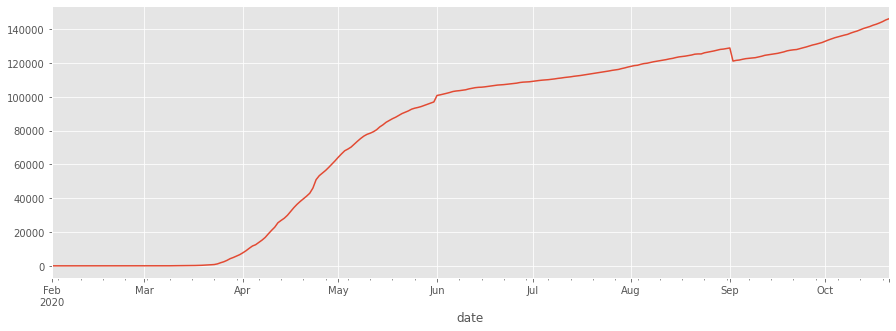

In [67]:
state_data[state_data['state'] == 'Massachusetts']['cases'].plot()

The data looks to be cumulative data.  We need to covert it back to incremental data to really trach trends.

In [68]:
def compute_daily(series):
    temp_series =  series.sub(series.shift(fill_value = 0)) 
    return temp_series.mask(temp_series < 0)

state_data[['daily_cases', 'daily_deaths']] = (
    state_data.groupby('state')[['cases', 'deaths']]
    .transform( compute_daily )
)

In [57]:
state_data.tail()

,state,fips,cases,deaths,daily_cases,daily_deaths
date,,,,,,
2020-10-21,Virginia,51,168772,3515,1018,30
2020-10-21,Washington,53,104624,2384,779,4
2020-10-21,West Virginia,54,20734,413,215,5
2020-10-21,Wisconsin,55,192225,1707,4327,47
2020-10-21,Wyoming,56,9848,61,322,0


<AxesSubplot:xlabel='date'>

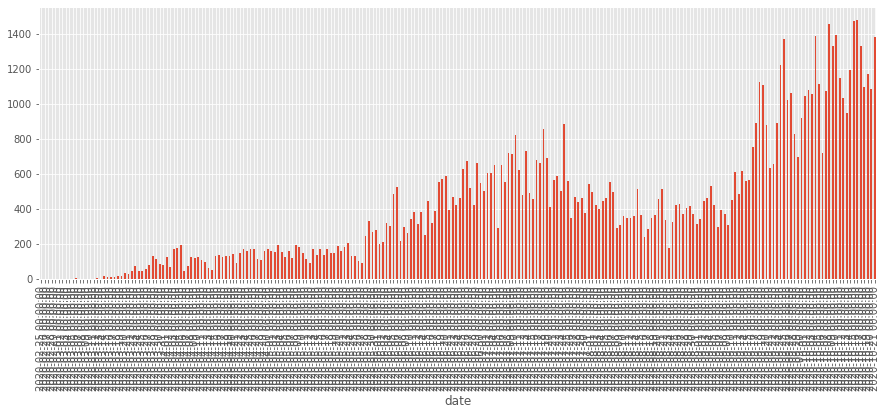

In [58]:
state_data[state_data['state'] == 'Utah']['daily_cases'].plot(kind='bar')

We also need to compute a moving average.  The NY Times uses a 14 day window which seems reasonable.

In [ ]:
# Compute Moving Average
# Fix X Axis Labels and scale


OK.  The next step is fo compute the per capita incident rate.  In order do this you will need to merge in an additional data file that contains the data for each state and county.



In [7]:
population_data = pd.read_csv('co-est2019-alldata.csv', usecols=['SUMLEV', 'REGION', 'DIVISION', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME', 'POPESTIMATE2019'], dtype='str', encoding='latin1')

population_data['POPESTIMATE2019'] = population_data['POPESTIMATE2019'].astype('float')

In [29]:
states = population_data.query("COUNTY == '000'")
states['PER100K'] = states['POPESTIMATE2019'].transform(lambda c: c/100000)

<ipython-input-29-a85f52396fd7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states['PER100K'] = states['POPESTIMATE2019'].transform(lambda c: c/100000)


In [9]:
states

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,POPESTIMATE2019,PER100K
0,040,3,6,01,000,Alabama,Alabama,4903185.0,49.03185
68,040,4,9,02,000,Alaska,Alaska,731545.0,7.31545
98,040,4,8,04,000,Arizona,Arizona,7278717.0,72.78717
114,040,3,7,05,000,Arkansas,Arkansas,3017804.0,30.17804
190,040,4,9,06,000,California,California,39512223.0,395.12223
249,040,4,8,08,000,Colorado,Colorado,5758736.0,57.58736
314,040,1,1,09,000,Connecticut,Connecticut,3565287.0,35.65287
323,040,3,5,10,000,Delaware,Delaware,973764.0,9.73764
327,040,3,5,11,000,District of Columbia,District of Columbia,705749.0,7.05749
329,040,3,5,12,000,Florida,Florida,21477737.0,214.77737


In [10]:
states['FIPS'] = states['STATE'] + states['COUNTY']

<ipython-input-10-9a95846e0e94>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states['FIPS'] = states['STATE'] + states['COUNTY']


In [28]:
state_data.head()

,state,fips,cases,deaths
date,,,,
2020-01-21,Washington,53,1,0
2020-01-22,Washington,53,1,0
2020-01-23,Washington,53,1,0
2020-01-24,Illinois,17,1,0
2020-01-24,Washington,53,1,0


In [69]:
merged_data = state_data.reset_index().merge(states, how = 'left', left_on='fips', right_on='STATE').set_index('date')


In [70]:
merged_data = merged_data.drop(columns=['DIVISION', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME'])

In [71]:
merged_data[['pop_adjusted_cases', 'pop_adjusted_deaths']] = (
    merged_data[['daily_cases', 'daily_deaths']]
    .transform(lambda s: s.divide(merged_data['PER100K']))
)



In [72]:
merged_data.groupby('state')['pop_adjusted_cases'].min()

state
Alabama                 0.122369
Alaska                  0.000000
Arizona                 0.000000
Arkansas                0.000000
California              0.000000
Colorado                0.000000
Connecticut             0.000000
Delaware                0.000000
District of Columbia    0.000000
Florida                 0.000000
Georgia                 0.000000
Hawaii                  0.000000
Idaho                   0.000000
Illinois                0.000000
Indiana                 0.000000
Iowa                    0.000000
Kansas                  0.000000
Kentucky                0.000000
Louisiana               0.000000
Maine                   0.000000
Maryland                0.000000
Massachusetts           0.000000
Michigan                0.000000
Minnesota               0.000000
Mississippi             0.000000
Missouri                0.000000
Montana                 0.000000
Nebraska                0.000000
Nevada                  0.000000
New Hampshire           0.000000
New 

<AxesSubplot:xlabel='date'>

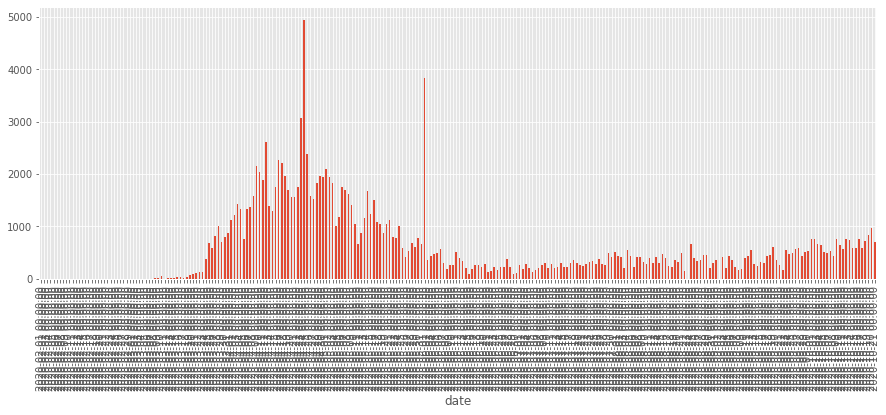

In [74]:
merged_data.query('state == "Massachusetts"')['daily_cases'].plot(kind = 'bar')